In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import rasterio

# Askervein Hill
see, e.g., Wagenbrenner et al. 2019, atmosphere, [doi:10.3390/atmos10110672](http://doi.org/10.3390/atmos10110672)

reference data can be found in https://github.com/nwagenbrenner/windninja-tools

In [2]:
zref = 10.0 # measurement height
Uref = 9.0 # estimated from digitized data in Fig 3b
wdir_deg = 210.0

kappa = 0.41
z0 = 0.03

In [3]:
refdir = '/Users/equon/windninja-tools/data'
pltfile = '/Users/equon/OneDrive/FIRE-SMART/Askervein/erf/anel_dz20/plt01142'

## read elevation map

In [4]:
with rasterio.open(f'{refdir}/askervein.tif') as src:
    # Read the data as a NumPy array (reads all bands by default)
    #image_array = src.read()
    band = 1
    elev = src.read(band)

    print(f"Image shape (bands, height, width): {elev.shape}")
    print(f"Coordinate Reference System (CRS): {src.crs}")
    print(f"Bounds: {src.bounds}")

elev = np.flipud(elev)

Image shape (bands, height, width): (257, 257)
Coordinate Reference System (CRS): EPSG:32630
Bounds: BoundingBox(left=-3011.71875, bottom=-3011.71875, right=3011.71875, top=3011.71875)


In [5]:
ny, nx = elev.shape
nx, ny

(257, 257)

In [6]:
x1 = np.linspace(0,1,nx) * (src.bounds.right - src.bounds.left) + src.bounds.left
y1 = np.linspace(0,1,ny) * (src.bounds.top - src.bounds.bottom) + src.bounds.bottom
xx,yy = np.meshgrid(x1,y1)

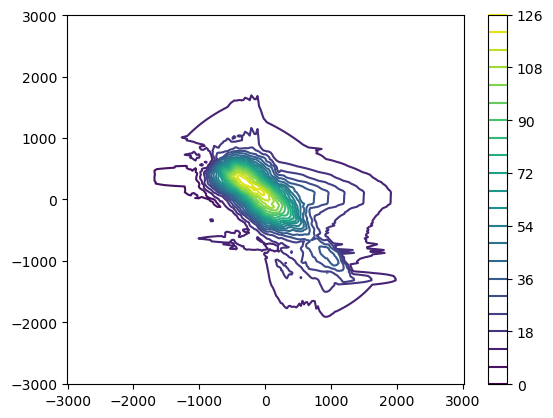

In [7]:
fig,ax = plt.subplots()
cont = ax.contour(xx,yy,elev, 21)
fig.colorbar(cont)

In [8]:
elev_max = np.max(elev)
imax,jmax = np.where(elev == elev_max)
print(elev_max)

124.837


In [9]:
interppts = (x1, y1)
interpfun = RegularGridInterpolator(interppts, elev.T)

## write terrain map for ERF

In [10]:
elev1 = elev.transpose().ravel()
with open('askervein.txt','w') as f:
    f.write(f'{nx}\n{ny}\n')
    for xval in x1:
        f.write(f'{xval}\n')
    for yval in y1:
        f.write(f'{yval}\n')
    for zval in elev1:
        f.write(f'{zval}\n')

## setup custom vertical levels for ERF

In [11]:
z1 = 0.9 # near-ground cell (center) height ~ 30 * z0
ztop = 727. # approx
#nz = 40
s0 = 1.3
s1 = 1.1
smax = 1.2
sdelta = 0.02

dz = [2 * z1]
zlevels = [0, dz[-1]]
while zlevels[-1] < 5:
    dz.append(s0 * dz[-1])
    zlevels.append(zlevels[-1] + dz[-1])
while zlevels[-1] < 100.:
    dz.append(s1 * dz[-1])
    zlevels.append(zlevels[-1] + dz[-1])
s = s1 + sdelta
while zlevels[-1] < ztop:
#while len(zlevels) <= nz:
    dz.append(s * dz[-1])
    zlevels.append(zlevels[-1] + dz[-1])
    s = min(s + sdelta, smax)

dz = np.array(dz)
zlevels = np.array(zlevels)
zcc = 0.5 * (zlevels[1:] + zlevels[:-1])
len(zcc)

print('stretching ratios:',dz[1:] / dz[:-1])

print('dz:',dz)

print(f'erf.terrain_z_levels =',' '.join([str(zval) for zval in zlevels]))

stretching ratios: [1.3  1.3  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1  1.1
 1.1  1.1  1.12 1.14 1.16 1.18 1.2  1.2  1.2  1.2  1.2  1.2  1.2  1.2
 1.2  1.2 ]
dz: [  1.8          2.34         3.042        3.3462       3.68082
   4.048902     4.4537922    4.89917142   5.38908856   5.92799742
   6.52079716   7.17287688   7.89016456   8.67918102   9.54709912
  10.50180903  11.55198994  12.93822873  14.74958075  17.10951367
  20.18922613  24.22707136  29.07248563  34.88698276  41.86437931
  50.23725517  60.28470621  72.34164745  86.80997694 104.17197233
 125.00636679]
erf.terrain_z_levels = 0.0 1.8 4.140000000000001 7.182000000000001 10.528200000000002 14.209020000000002 18.257922000000004 22.711714200000007 27.61088562000001 32.99997418200001 38.92797160020001 45.44876876022001 52.62164563624202 60.51181019986623 69.19099121985286 78.73809034183816 89.23989937602198 100.79188931362418 113.73011804373866 128.47969879606916 145.58921246877253 165.77843860256252 190.0055099631105

## check inflow

In [12]:
inflow_obs = pd.read_csv('Fig3b_obs_digitized.csv')
ddz = inflow_obs.iloc[:2].diff()
dUdz = (ddz['U'] / ddz['z']).iloc[1]
z1 = inflow_obs['z'].iloc[0] + 0.5 * ddz['z'].iloc[1]
print(z1, dUdz)
inflow_obs.iloc[:2]

4.017397950828238 0.3852590449023052


,U,z
0,7.109375,3.016144
1,7.880859,5.018652


In [13]:
ustar = dUdz * kappa * z1
print(ustar)

0.6345729479867117


In [14]:
Ulog = ustar/kappa * np.log(zcc/z0)
Uinf = 5.3792 * zcc**0.2113

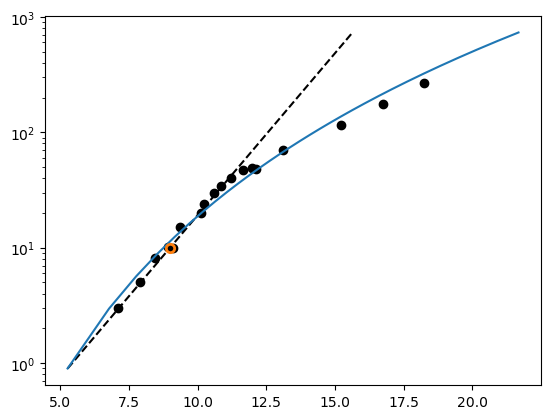

In [15]:
plt.semilogy(inflow_obs['U'], inflow_obs['z'], 'ko')
plt.semilogy(Ulog, zcc, 'k--')
plt.semilogy(Uinf, zcc)
plt.plot(Uref, zref, 'o', mfc='none', mew=2)

## write initial and boundary conditions for ERF

In [16]:
Tsurf = 300.0
ang = np.radians(270.0 - wdir_deg)

with open('inflow_powerlaw.txt','w') as f:
    for zlev,Ulev in zip(zcc, Uinf):
        f.write(f'{zlev:10f} {Ulev * np.cos(ang):10g} {Ulev * np.sin(ang):10g} 0.0\n')

with open('sounding_powerlaw.txt','w') as f:
    f.write(f'1000.0 {Tsurf:g} 0.0')
    for zlev,Ulev in zip(zcc, Uinf):
        f.write(f'{zlev:10f} {Tsurf:g} 0.0 {Ulev * np.cos(ang):10g} {Ulev * np.sin(ang):10g}\n')

## get measurement locs and data for comparison
from `windninja-tools` repo

In [17]:
def load_line_locs(name):
    line = pd.read_csv(f'{refdir}/observed_data/line_{name}.csv')
    line = line.dropna(how='all')
    my_heights = interpfun((line['x'], line['y'])) + zref
    print('elev MAE:',np.max(np.abs(my_heights - line['z'])))
    return line

lineA = load_line_locs('a')
lineAA = load_line_locs('aa')
lineB = load_line_locs('b')

elev MAE: 0.5016060608623896
elev MAE: 1.1531253496995362
elev MAE: 0.5743773600995183


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


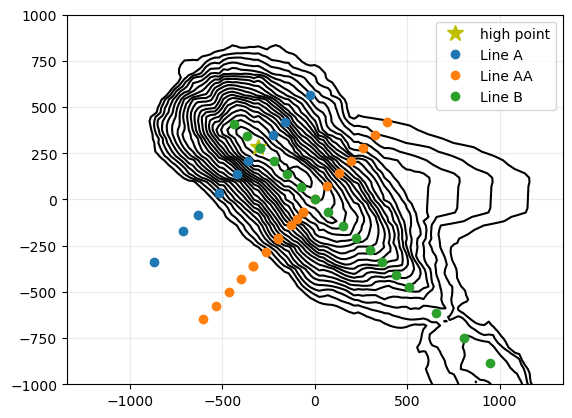

In [18]:
fig,ax = plt.subplots()
cont = ax.contour(xx,yy,elev,np.arange(25,126,5),colors='k')
ax.plot(xx[imax,jmax], yy[imax,jmax], 'y*', markersize=12, label='high point')
ax.plot(lineA['x'], lineA['y'], 'o', label='Line A')
ax.plot(lineAA['x'], lineAA['y'], 'o', label='Line AA')
ax.plot(lineB['x'], lineB['y'], 'o', label='Line B')
ax.axis('equal')
ax.legend(loc='best')
ax.set_xlim((-1000,1000))
ax.set_ylim((-1000,1000))
ax.grid(alpha=0.25)

In [19]:
def load_line_obs(name):
    linedist = pd.read_csv(f'{refdir}/observed_data/dist_line_{name}.csv',header=1,names=['dist'])
    linewspd = pd.read_csv(f'{refdir}/observed_data/line_{name}_observed.csv',header=1,names=['wspd'])
    linewspd['speedup'] = (linewspd['wspd'] - Uref) / Uref
    try:
        linewdir = pd.read_csv(f'{refdir}/observed_data/line_{name}_angle_observed.csv',header=1,names=['wdir'])
    except FileNotFoundError:
        df = pd.concat([linedist, linewspd], axis=1)
    else:
        df = pd.concat([linedist, linewspd, linewdir], axis=1)
    return df.loc[df['wspd']>0,:]

In [20]:
refA = load_line_obs('a')
refAA = load_line_obs('aa')
refB = load_line_obs('b')

## postprocess ERF soln

In [21]:
soln = xr.open_dataset(pltfile)
soln = soln.squeeze()
soln['wspd'] = np.sqrt(soln['x_velocity']**2 + soln['y_velocity']**2 + soln['z_velocity']**2)

/Users/equon/miniforge3/envs/forge/lib/python3.11/site-packages/xarray/backends/plugins.py:110: RuntimeWarning: Engine 'gini' loading failed:
module 'numpy' has no attribute 'cumproduct'
  external_backend_entrypoints = backends_dict_from_pkg(entrypoints_unique)


In [22]:
%%time
def postproc_line(line):
    #line['z'] = interpfun((line['x'], line['y'])) + zref
    
    imax = np.argmax(line['z'])
    x0, y0 = line.iloc[imax][['x','y']]
    
    dist = np.empty_like(line['z'])
    wspd = np.empty_like(line['z'])
    speedup = np.empty_like(line['z'])
    for i,row in line.iterrows():
        dx = row['x'] - x0
        dy = row['y'] - y0
        dist[i] = np.sign(dx) * np.sqrt(dx*dx + dy*dy)
        
        col = soln[['z_phys','wspd']].interp(x=row['x'], y=row['y'])
        wspd[i] = np.interp(row['z'], col['z_phys'], col['wspd'])
        speedup[i] = (wspd[i] - Uref) / Uref # fractional speedup
    line['wspd'] = wspd
    line['speedup'] = speedup
    line['dist'] = dist

postproc_line(lineA)
postproc_line(lineAA)
postproc_line(lineB)

# CPU times: user 20 s, sys: 3.5 s, total: 23.5 s
# Wall time: 22.4 s

CPU times: user 21.1 s, sys: 4.26 s, total: 25.4 s
Wall time: 24.7 s


## c.f. Fig. 8

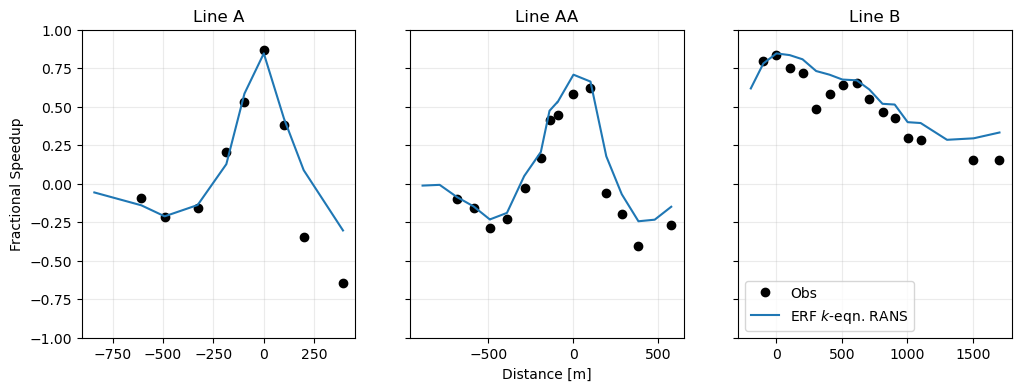

In [25]:
fig,axs = plt.subplots(ncols=3, sharey=True, figsize=(12,4))
axs[0].plot(refA['dist'],  refA['speedup'], 'ko')
axs[1].plot(refAA['dist'], refAA['speedup'], 'ko')
axs[2].plot(refB['dist'],  refB['speedup'], 'ko', label='Obs')

axs[0].plot(lineA['dist'],  lineA['speedup'])
axs[1].plot(lineAA['dist'], lineAA['speedup'])
axs[2].plot(lineB['dist'],  lineB['speedup'], label='ERF $k$-eqn. RANS')

for ax in axs:
    ax.grid(alpha=0.25)
ax.set_ylim(-1,1)
axs[1].set_xlabel('Distance [m]')
axs[0].set_ylabel('Fractional Speedup')
axs[0].set_title('Line A')
axs[1].set_title('Line AA')
axs[2].set_title('Line B')
axs[2].legend(loc='best')

fig.savefig('askervein_speedup_transects.png',bbox_inches='tight')

Text(0, 0.5, 'Wind Speed [m/s]')

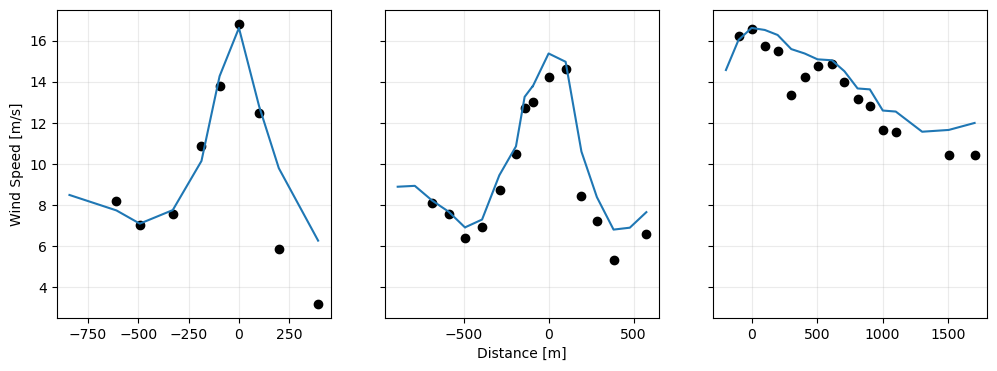

In [24]:
fig,axs = plt.subplots(ncols=3, sharey=True, figsize=(12,4))
axs[0].plot(refA['dist'],  refA['wspd'], 'ko')
axs[1].plot(refAA['dist'], refAA['wspd'], 'ko')
axs[2].plot(refB['dist'],  refB['wspd'], 'ko')

axs[0].plot(lineA['dist'],  lineA['wspd'])
axs[1].plot(lineAA['dist'], lineAA['wspd'])
axs[2].plot(lineB['dist'],  lineB['wspd'])

for ax in axs:
    ax.grid(alpha=0.25)
axs[1].set_xlabel('Distance [m]')
axs[0].set_ylabel('Wind Speed [m/s]')